In [3]:
import jax.numpy as jnp
import unxt as u
import coordinax as cx
import galax.coordinates as gc
import galax.dynamics as gd
import galax.potential as gp
from unxt import Quantity
import jax
import matplotlib.pyplot as plt


We will first generate a stream using galax

In [4]:
w0 = gc.PhaseSpacePosition(
    q=u.Quantity([20, 10, 10], "kpc"),
    p=u.Quantity([0, 250, 0], "km/s"),
    t=u.Quantity(-4, "Gyr"),
)


pot = gp.MilkyWayPotential()
mockgen = gd.MockStreamGenerator(
    df=gd.FardalStreamDF(),
    potential=pot,
)
t_release = Quantity(jnp.linspace(-4, 0, 1_000), "Gyr")
prog_mass = Quantity(1e4, "Msun")

In [5]:
key = jax.random.PRNGKey(0)
mockstream, prog_f = mockgen.run(
    key, ts=t_release, prog_w0=w0, prog_mass=prog_mass
)


- $\texttt{streamframe}$ requires a $N \times 6$ array of phase-space positions, representing the stream. The position units are in kpc, velocity units in kpc/Myr. 
- We also require the progenitor's final location (or some approximation) to get a stream-aligned frame. This is represented with a length 6 1d array [pos, vel].

Below, we will package the output of the $\texttt{galax}$ mockstream to fit the above format.



In [6]:
pos = jnp.vstack([mockstream.q.x.value,
            mockstream.q.y.value,
            mockstream.q.z.value]).T

vel = jnp.vstack([mockstream.p.d_x.value,
            mockstream.p.d_y.value,
            mockstream.p.d_z.value]).T

posvel = jnp.hstack([pos,vel])


prog_posvel = jnp.array([prog_f.q.x.value,
                         prog_f.q.y.value,
                         prog_f.q.z.value,
                         prog_f.p.d_x.value,
                         prog_f.p.d_y.value,
                         prog_f.p.d_z.value]).T



In [7]:
from streamframe import streamframe as sf

In [8]:
stream_obj = sf(sim_coords=posvel,prog_sim_coord=prog_posvel)
coords = stream_obj.stream_coords
coords.keys()

dict_keys(['phi1', 'phi2', 'pm_phi1', 'pm_phi2', 'r', 'vr'])

Default output units are
- phi1: deg
- phi2: deg
- pm_phi1: mas/yr
- pm_phi2: mas/yr
- r: (galactocentric) kpc
- vr: km/s


streamframe output shown below

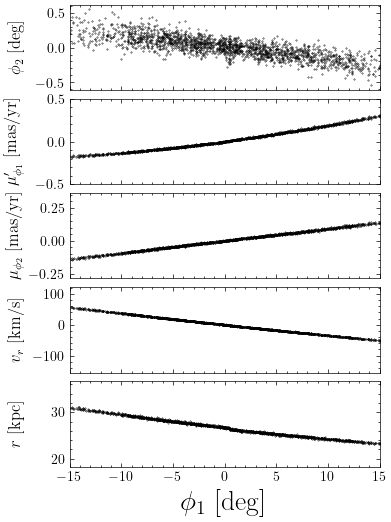

In [9]:
fig, ax = plt.subplots(5,1)
fig.set_size_inches(4,6)
ax[0].scatter(coords['phi1'], coords['phi2'],s=.1,color='k',rasterized=True)
ax[1].scatter(coords['phi1'], coords['pm_phi1'],s=.1,color='k',rasterized=True)
ax[2].scatter(coords['phi1'], coords['pm_phi2'],s=.1,color='k',rasterized=True)
ax[3].scatter(coords['phi1'], coords['vr'],s=.1,color='k',rasterized=True)
ax[4].scatter(coords['phi1'], coords['r'],s=.1,color='k',rasterized=True)

fs = 12
ax[-1].set_xlabel(r'$\phi_1$ [deg]',fontsize=20)
ax[0].set_ylabel(r'$\phi_2$ [deg]',fontsize=fs)
ax[1].set_ylabel(r'$\mu^\prime_{\phi_1}$ [mas/yr]',fontsize=fs,)
ax[2].set_ylabel(r'$\mu_{\phi_2}$ [mas/yr]',fontsize=fs)
ax[3].set_ylabel(r'$v_r$ [km/s]',fontsize=fs)
ax[4].set_ylabel(r'$r$ [kpc]',fontsize=fs)

ax[1].set_ylim(-.5,.5)

for i in range(5):
    ax[i].set_xlim(-15,15)

for i in range(4):
    ax[i].set_xticklabels([])

fig.align_ylabels()
fig.subplots_adjust(hspace=0.1)